gg-napari-env

In [1]:
import napari
from napari_czifile2 import napari_get_reader
from cellpose import models, plot, utils, core, models, train
from cellpose.io import logger_setup
import cellpose.io as cio 
import torch 
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import find_contours
import pandas as pd
import skimage.exposure as exposure
from skimage.morphology import remove_small_objects
import numpy as np
from skimage.measure import label, regionprops
import seaborn as sns
import os 
import sys 
from skimage.transform import resize
from skimage.filters import threshold_otsu, threshold_yen, try_all_threshold
from skimage.exposure import equalize_adapthist
from skimage.measure import label, regionprops
from scipy.ndimage import binary_erosion, gaussian_filter, binary_dilation, binary_fill_holes
from skimage import exposure
import sys 
from plotting import * 
import warnings
import matplotlib.font_manager as fm
fm.fontManager.__init__()
warnings.filterwarnings("ignore")
use_GPU = core.use_gpu()
torch.cuda.empty_cache()
print('>>> GPU activated? %d'%use_GPU)
logger_setup()

Initializing plotting package
>>> GPU activated? 1
2025-04-04 10:50:32,868 [INFO] WRITING LOG OUTPUT TO /home/tracking/.cellpose/run.log
2025-04-04 10:50:32,869 [INFO] 
cellpose version: 	3.1.0 
platform:       	linux 
python version: 	3.12.8 
torch version:  	2.5.1+cu124


(<Logger cellpose.io (INFO)>, PosixPath('/home/tracking/.cellpose/run.log'))

## Export Images for Training 

In [29]:
input = '20250328 1 P14 T79-intergenic-b2-647 T79-exonic-b1-546 DAPI'
input_dir = f'../raw-data/{input}/'
assert os.path.exists(input_dir), 'Input directory does not exist'
czi_files = [f for f in os.listdir(input_dir) if f.endswith('.czi')]
print(f"Found {len(czi_files)} czi files in {input_dir}")
print(czi_files)

Found 5 czi files in ../raw-data/20250328 1 P14 T79-intergenic-b2-647 T79-exonic-b1-546 DAPI/
['20250328 1 T79 sample 1.czi', '20250328 1 T79 sample 5.czi', '20250328 1 T79 sample 2.czi', '20250328 1 T79 sample 3.czi', '20250328 1 T79 sample 4.czi']


In [30]:
file = czi_files[0]
file_path = os.path.join(input_dir, file)
reader = napari_get_reader(file_path)
if reader is not None:
    layer_data = reader(file_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {file_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

Loaded ../raw-data/20250328 1 P14 T79-intergenic-b2-647 T79-exonic-b1-546 DAPI/20250328 1 T79 sample 1.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 29259.974395751953, 31219.198837280273), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'DAPI-T2', 'AF647-T2']}
Image shape: (1, 79, 3, 2048, 2048)


In [31]:
# Export to a folder for training 
output_dir = f"../cellpose-model-training/{file.replace(".czi", "")} slices"
os.makedirs(output_dir, exist_ok=True)

# Sizes of zooms 
n_slices = 10
np.random.seed(9)
dapi_index = metadata['name'].index([name for name in metadata['name'] if 'DAPI' in name][0])
slices = np.random.choice(image_data.shape[1], n_slices)
for i, s in enumerate(slices):
    slice_data = image_data[0,s,dapi_index,:,:]
    io.imsave(f"{output_dir}/{file.replace(".czi", f"_{i}.tif")}", slice_data)
    print(f"Saved {output_dir}/{file.replace('.czi', f'_{i}.tif')}")

Saved ../cellpose-model-training/20250328 1 T79 sample 1 slices/20250328 1 T79 sample 1_0.tif
Saved ../cellpose-model-training/20250328 1 T79 sample 1 slices/20250328 1 T79 sample 1_1.tif
Saved ../cellpose-model-training/20250328 1 T79 sample 1 slices/20250328 1 T79 sample 1_2.tif
Saved ../cellpose-model-training/20250328 1 T79 sample 1 slices/20250328 1 T79 sample 1_3.tif
Saved ../cellpose-model-training/20250328 1 T79 sample 1 slices/20250328 1 T79 sample 1_4.tif
Saved ../cellpose-model-training/20250328 1 T79 sample 1 slices/20250328 1 T79 sample 1_5.tif
Saved ../cellpose-model-training/20250328 1 T79 sample 1 slices/20250328 1 T79 sample 1_6.tif
Saved ../cellpose-model-training/20250328 1 T79 sample 1 slices/20250328 1 T79 sample 1_7.tif
Saved ../cellpose-model-training/20250328 1 T79 sample 1 slices/20250328 1 T79 sample 1_8.tif
Saved ../cellpose-model-training/20250328 1 T79 sample 1 slices/20250328 1 T79 sample 1_9.tif


## Train Model 

In [2]:
train_dir = '../cellpose-model-training/model_B_only_OSNs/train'
test_dir = '../cellpose-model-training/model_B_only_OSNs/test'

output = cio.load_train_test_data(train_dir, test_dir, mask_filter="_seg.npy")
train_images, train_labels, image_names, test_images, test_labels, image_names_test = output

2025-04-04 10:50:32,899 [INFO] not all flows are present, running flow generation for all images


2025-04-04 10:50:42,180 [INFO] 16 / 16 images in ../cellpose-model-training/model_B_only_OSNs/train folder have labels
2025-04-04 10:50:42,198 [INFO] not all flows are present, running flow generation for all images
2025-04-04 10:50:46,433 [INFO] 8 / 8 images in ../cellpose-model-training/model_B_only_OSNs/test folder have labels


LR = 0.1, n_epochs=300, weight_decay=0.0001

In [3]:
model = models.CellposeModel(model_type="nuclei", gpu=True) 
model_name = "model_B_only_OSNs"
model_path = '../cellpose-model-training/model_B_only_OSNs'
model_path, train_losses, test_losses = train.train_seg(model.net,
                            train_data=train_images, train_labels=train_labels,
                            channels=[0, 0], # DAPI 
                            save_path=model_path,
                            test_data=test_images, test_labels=test_labels,
                            weight_decay=1e-5, SGD=True, learning_rate=0.005, rescale=True, 
                            n_epochs=500, model_name=model_name)

2025-04-04 10:50:55,947 [INFO] >> nuclei << model set to be used
2025-04-04 10:50:55,976 [INFO] ** TORCH CUDA version installed and working. **
2025-04-04 10:50:55,978 [INFO] >>>> using GPU (CUDA)
2025-04-04 10:50:56,015 [INFO] >>>> loading model /home/tracking/.cellpose/models/nucleitorch_0
2025-04-04 10:50:56,201 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2025-04-04 10:50:56,203 [INFO] computing flows for labels


100%|██████████| 16/16 [00:03<00:00,  4.54it/s]

2025-04-04 10:50:59,798 [INFO] computing flows for labels



100%|██████████| 8/8 [00:01<00:00,  5.80it/s]

2025-04-04 10:51:01,206 [INFO] >>> computing diameters



100%|██████████| 8/8 [00:00<00:00, 95.91it/s]

2025-04-04 10:51:01,464 [WARNING] 1 train images with number of masks less than min_train_masks (5), removing from train set
2025-04-04 10:51:01,464 [INFO] >>> using channels [0, 0]
2025-04-04 10:51:01,465 [INFO] >>> normalizing {'lowhigh': None, 'percentile': None, 'normalize': True, 'norm3D': True, 'sharpen_radius': 0, 'smooth_radius': 0, 'tile_norm_blocksize': 0, 'tile_norm_smooth3D': 1, 'invert': False}


2025-04-04 10:51:03,725 [INFO] >>> n_epochs=500, n_train=15, n_test=8
2025-04-04 10:51:03,726 [INFO] >>> SGD, learning_rate=0.00500, weight_decay=0.00001, momentum=0.900
2025-04-04 10:51:06,982 [INFO] >>> saving model to ../cellpose-model-training/model_B_only_OSNs/models/model_B_only_OSNs
2025-04-04 10:51:10,054 [INFO] 0, train_loss=0.6061, test_loss=0.5810, LR=0.000000, time 3.11s
2025-04-04 10:51:14,250 [INFO] 5, train_loss=0.6836, test_loss=0.4907, LR=0.002778, time 7.31s
2025-04-04 10:51:18,465 [INFO] 10, train_loss=0.5207, test_loss=0.3757, LR=0.005000, time 11.53s
2025-04-04 10:51:26,588 [INFO] 20, train_loss=0.3940, test_loss=0.3110, LR=0.005000, time 19.65s
2025-04-04 10:51:34,979 [INFO] 30, train_loss=0.3294, test_loss=0.2965, LR=0.005000, time 28.04s
2025-04-04 10:51:42,068 [INFO] 40, train_loss=0.2781, test_loss=0.2810, LR=0.005000, time 35.13s
2025-04-04 10:51:50,214 [INFO] 50, train_loss=0.2758, test_loss=0.2826, LR=0.005000, time 43.27s
2025-04-04 10:51:59,206 [INFO] 60,

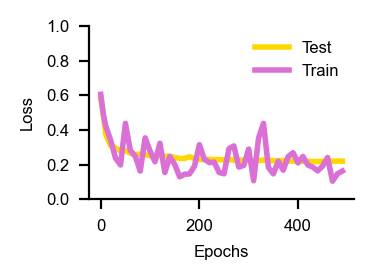

In [4]:
# Plot losses
white_plotting()
f, ax = plt.subplots(1, 1, figsize=(2, 1.5), dpi=200)
ax.plot(np.where(test_losses > 0)[0], test_losses[test_losses > 0], label='Test', color='gold', lw=2)
ax.plot(np.where(test_losses > 0)[0], train_losses[test_losses > 0], label='Train', color='orchid', lw=2)
ax.set_xlabel('Epochs', fontsize=6)
ax.set_ylabel('Loss', fontsize=6)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(fontsize=6, frameon=False)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/{model_name}_losses.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

In [5]:
# Save train and test losses
model_path = '../cellpose-model-training/model_B_only_OSNs/models'
os.makedirs(model_path, exist_ok=True)
model_name = "model_B_only_OSNs"
np.save(f"{model_path}/train_losses_{model_name}.npy", train_losses)
np.save(f"{model_path}/test_losses_{model_name}.npy", test_losses)

In [ ]:
# Load train and test losses
model_path = '../cellpose-model-training/model_B_only_OSNs/models'
model_name = "model_B_only_OSNs"
train_losses = np.load(f"{model_path}/train_losses_{model_name}.npy")
test_losses = np.load(f"{model_path}/test_losses_{model_name}.npy")

## Test Model on Held-Out Data 

In [43]:
# Load trained model 
model_path = '../cellpose-model-training/model_B_only_OSNs/models/model_B_only_OSNs'
model = models.CellposeModel(gpu=True, pretrained_model=model_path)

2025-03-31 16:36:50,551 [INFO] ** TORCH CUDA version installed and working. **
2025-03-31 16:36:50,552 [INFO] >>>> using GPU (CUDA)


2025-03-31 16:36:50,585 [INFO] >>>> loading model ../cellpose-model-training/model_B_only_OSNs/models/model_B_only_OSNs
2025-03-31 16:36:50,614 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2025-03-31 16:36:50,615 [INFO] >>>> model diam_labels =  29.437 (mean diameter of training ROIs)


In [44]:
def random_colormap_transparent(mask):
    unique_labels = np.unique(mask)
    colored_mask = np.zeros((*mask.shape, 4), dtype=np.uint8)  # RGBA image

    # Assign random colors
    np.random.seed(0)  # Ensure reproducibility
    colors = np.random.randint(0, 255, size=(len(unique_labels), 3), dtype=np.uint8)
    colors = np.hstack((colors, np.full((len(unique_labels), 1), 255, dtype=np.uint8)))  # Add full opacity

    colors[0] = [0, 0, 0, 0]  # Make background transparent

    for i, label in enumerate(unique_labels):
        colored_mask[mask == label] = colors[i]

    return colored_mask

In [45]:
def set_min_max(channel, min_val, max_val):
    """
    Adjusts the contrast of the channel by setting the minimum and maximum values.
    Maps values in the range [min_val, max_val] to [0, 255].

    Args:
    - channel: Input image channel (2D array)
    - min_val: The minimum value to scale to
    - max_val: The maximum value to scale to

    Returns:
    - A contrast-adjusted channel, scaled to the range [0, 255]
    """
    # Ensure min_val and max_val are not the same, otherwise handle as special case
    if min_val == max_val:
        return np.zeros_like(channel)  # If min == max, return all zeros

    # Clip the values of the channel to the range [min_val, max_val]
    clipped = np.clip(channel, min_val, max_val)

    # Rescale the clipped values to the range [0, 255]
    # Normalize to [0, 1] and then scale to [0, 255]
    rescaled = (clipped - min_val) / (max_val - min_val) * 255
    
    return np.clip(rescaled, 0, 255)  # Ensure the values remain in the [0, 255] range



In [46]:
def filter_rois_by_size(rois, min_area_um2, pixel_x): 
    """
    Filters ROIs by area.

    Args:
    - rois: A list of ROIs (2D numpy arrays)
    - min_area: The minimum area of a ROI to keep

    Returns:
    - A list of filtered ROIs
    """
    if np.max(rois) == 0:
        return rois
    min_area_pixels = min_area_um2 / (pixel_x ** 2)  # Convert min_area_um2 to pixels
    regions = regionprops(rois)  # Get region properties for each ROI
    filtered_rois = np.zeros_like(rois)  # Initialize filtered ROIs
    for i, region in enumerate(regions):
        if region.area >= min_area_pixels:
            filtered_rois[rois == region.label] = i+1 
    return filtered_rois

In [47]:
def normalize_stack_by_dapi(image, dapi_channel=0, method='mean', eps=1e-8):
    """
    Normalize all channels in a z-stack using DAPI intensity as reference.

    Parameters:
    - image: np.ndarray, shape (Z, C, X, Y)
    - dapi_channel: int, index of the DAPI channel (in the C dimension)
    - method: str, 'mean', 'median', or 'max' for calculating DAPI intensity per z-slice
    - eps: small value to avoid division by zero

    Returns:
    - corrected: np.ndarray, shape (Z, C, X, Y)
    """
    
    z, c, x, y = image.shape
    corrected = np.zeros_like(image, dtype=np.uint8)

    # Extract DAPI channel across z
    dapi_stack = image[:, dapi_channel, :, :]

    # Compute per-slice intensity
    if method == 'mean':
        dapi_intensity = dapi_stack.mean(axis=(1, 2))
    elif method == 'median':
        dapi_intensity = np.median(dapi_stack, axis=(1, 2))
    elif method == 'max':
        dapi_intensity = dapi_stack.max(axis=(1, 2))
    else:
        raise ValueError("method must be 'mean', 'median', or 'max'")

    # Normalize: scale each slice by the ratio of max intensity to current slice intensity
    dapi_ref = np.max(dapi_intensity)
    correction_factors = dapi_ref / (dapi_intensity + eps)

    for z_idx in range(z):
        for ch in range(c):
            corrected[z_idx, ch] = (image[z_idx, ch] * correction_factors[z_idx])

    # Clip values to ensure they are within valid range for uint8
    corrected = np.clip(corrected, 0, 255).astype(np.uint8)
    
    return corrected


In [48]:
input = '20250328 1 P14 T79-intergenic-b2-647 T79-exonic-b1-546 DAPI'
input_dir = f'../raw-data/{input}/'
assert os.path.exists(input_dir), 'Input directory does not exist'
czi_files = [f for f in os.listdir(input_dir) if f.endswith('.czi')]
print(f"Found {len(czi_files)} czi files in {input_dir}")
print(czi_files)

Found 5 czi files in ../raw-data/20250328 1 P14 T79-intergenic-b2-647 T79-exonic-b1-546 DAPI/
['20250328 1 T79 sample 1.czi', '20250328 1 T79 sample 5.czi', '20250328 1 T79 sample 2.czi', '20250328 1 T79 sample 3.czi', '20250328 1 T79 sample 4.czi']


In [49]:
file = czi_files[0]
file_path = os.path.join(input_dir, file)
reader = napari_get_reader(file_path)
if reader is not None:
    layer_data = reader(file_path)
    image_data, metadata, layer_type = layer_data[0]
    image_data = np.squeeze(image_data)  # Remove any singleton dimensions
    dapi_index = metadata['name'].index([name for name in metadata['name'] if 'DAPI' in name][0])
    image_data = normalize_stack_by_dapi(image_data, dapi_channel=dapi_index, method='mean')
    print(f"Loaded {file_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

Loaded ../raw-data/20250328 1 P14 T79-intergenic-b2-647 T79-exonic-b1-546 DAPI/20250328 1 T79 sample 1.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 29259.974395751953, 31219.198837280273), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'DAPI-T2', 'AF647-T2']}
Image shape: (79, 3, 2048, 2048)


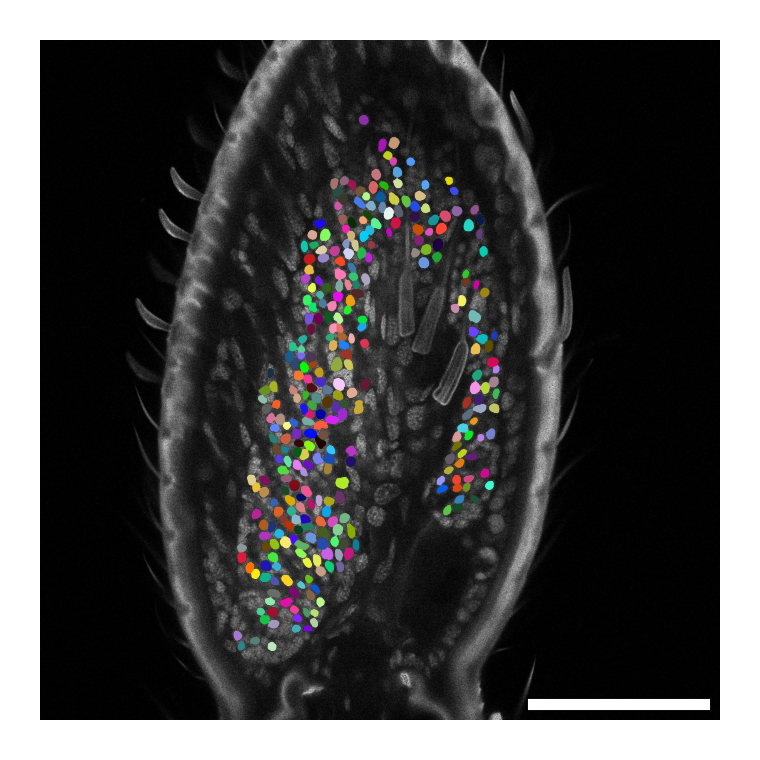

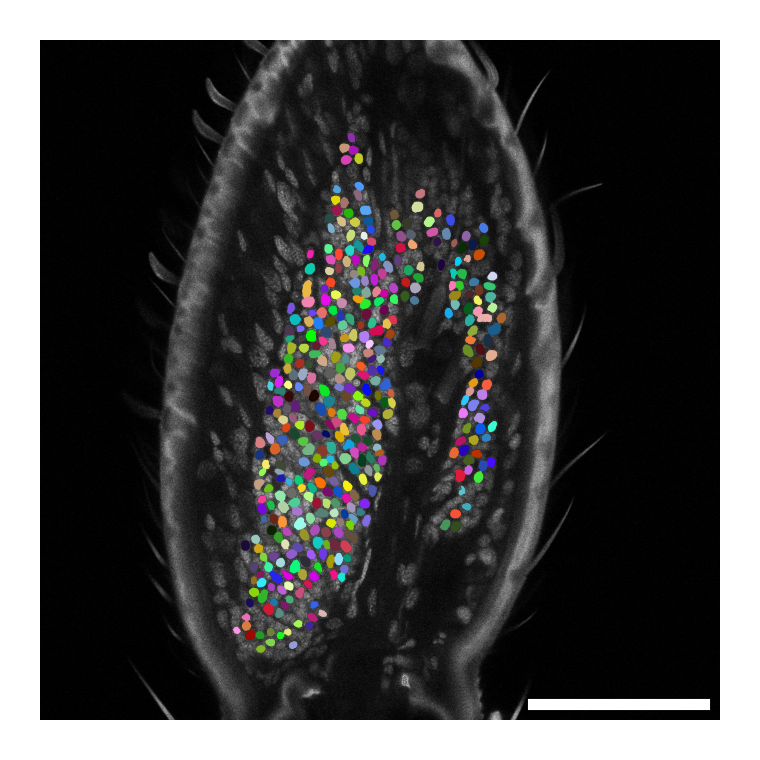

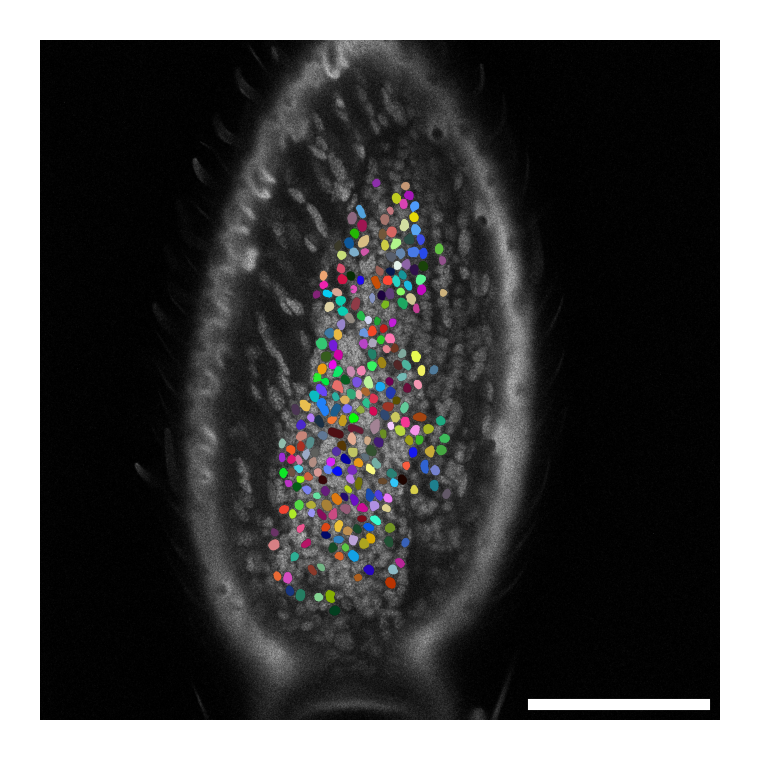

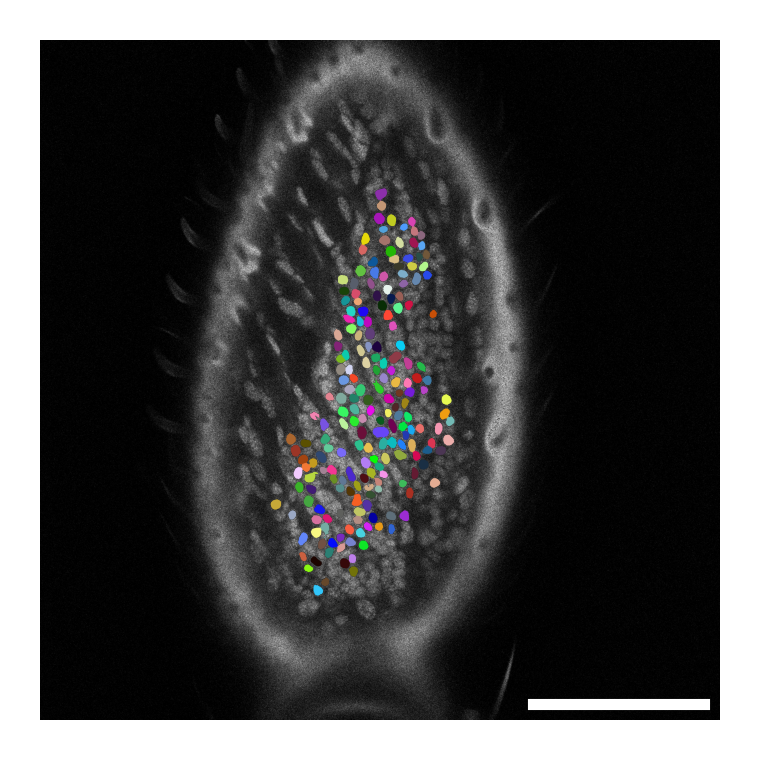

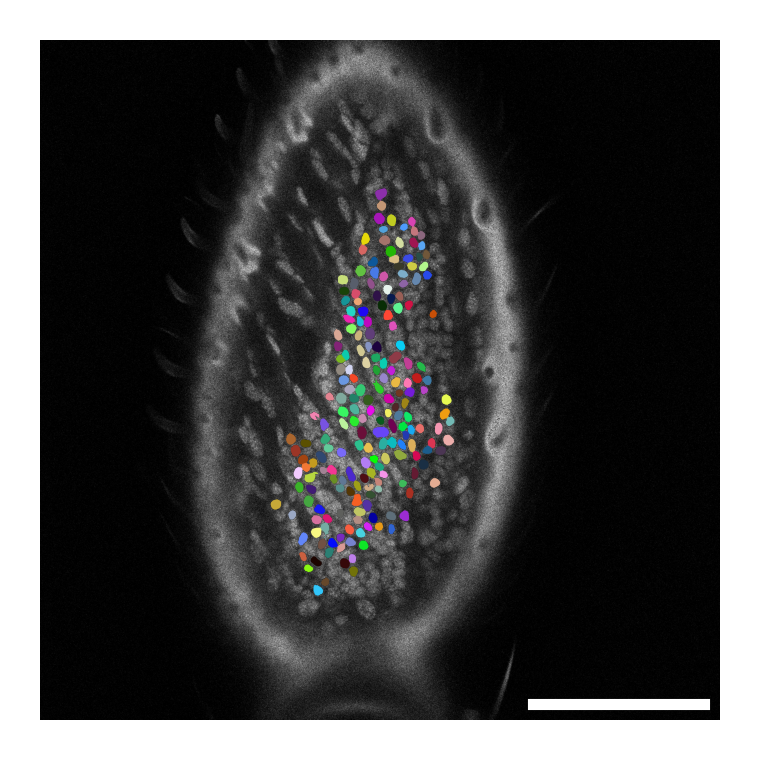

In [50]:
# choose 6 random zs 
num_z = 5
np.random.seed(0)
z_slices = image_data.shape[0]
z_indices = np.random.choice(range(z_slices), num_z)
#z_indices = [56]
dapi_index = metadata['name'].index([name for name in metadata['name'] if 'DAPI' in name][0])
gamma = 0.5  # <1 to brighten, >1 to darken
pixel_x = metadata['scale'][2]
nucleus_diameter = 3 / pixel_x

# Plot each channel for each z slice and the masks
for i, z in enumerate(z_indices):
    img = image_data[z, dapi_index, :, :]    
    fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=400) 
    ax.imshow(set_min_max(img, 0, 255), cmap='gray')
    rois, flows, styles = model.eval(img, diameter=nucleus_diameter)
    rois = filter_rois_by_size(rois, 4, pixel_x)
    ax.imshow(random_colormap_transparent(rois)) 
    ax.axis('off')
    # Get scale for scale bar 
    x_scale = 50 / metadata['scale'][2] # 5 um in pixels 
    ax.plot([img.shape[1] - 50 - x_scale, img.shape[1] - 50], [img.shape[0] - 50, img.shape[0] - 50], color='white', lw=2)
    plt.tight_layout() 
    #plt.savefig(f"../figures/OOS-examples/{file.replace('.czi', f'_z{z}.pdf')}", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
    plt.show()